# Méthodes de Monte Carlo par Chaînes de Markov (MCMC)
# Implémentation de Metropolis-Hastings et Gibbs Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, norm, gamma
import pandas as pd

plt.style.use('seaborn-v0_8')
np.random.seed(0)

## ALGORITHME DE METROPOLIS-HASTINGS

In [2]:
def metropolis_hastings(target_log_prob, proposal_func, initial_state, n_samples, 
                       proposal_std=1.0, burn_in=1000):
    """
    Implémentation de l'algorithme Metropolis-Hastings
    
    Paramètres:
    -----------
    target_log_prob : fonction
        Log-probabilité de la distribution cible
    proposal_func : fonction
        Fonction de proposition pour générer les nouveaux états
    initial_state : array
        État initial de la chaîne
    n_samples : int
        Nombre d'échantillons à générer
    proposal_std : float
        Écart-type de la proposition (pour une marche aléatoire normale)
    burn_in : int
        Nombre d'échantillons à ignorer au début (période de chauffe)
    
    Retourne:
    ---------
    samples : array
        Échantillons générés
    acceptance_rate : float
        Taux d'acceptation
    """
    
    # Initialisation
    samples = []
    current_state = np.array(initial_state)
    current_log_prob = target_log_prob(current_state)
    n_accepted = 0
    
    for i in range(n_samples + burn_in):
        # Proposition d'un nouvel état
        proposed_state = proposal_func(current_state, proposal_std)
        proposed_log_prob = target_log_prob(proposed_state)
        
        # Calcul du ratio d'acceptation (en log)
        log_alpha = min(0, proposed_log_prob - current_log_prob)
        
        # Décision d'acceptation/rejet
        if np.log(np.random.rand()) < log_alpha:
            current_state = proposed_state
            current_log_prob = proposed_log_prob
            n_accepted += 1
        
        # Stockage (après burn-in)
        if i >= burn_in:
            samples.append(current_state.copy())
    
    acceptance_rate = n_accepted / (n_samples + burn_in)
    return np.array(samples), acceptance_rate

### Proposition de l'algorithme

In [3]:
def normal_proposal(current_state, std):
    """Proposition de marche aléatoire normale"""
    return current_state + np.random.normal(0, std, size=current_state.shape)

### Univarié

=== EXEMPLE 1: DISTRIBUTION NORMALE UNIVARIÉE ===
Taux d'acceptation: 0.633
Moyenne échantillonnée: 1.976
Écart-type échantillonné: 1.516


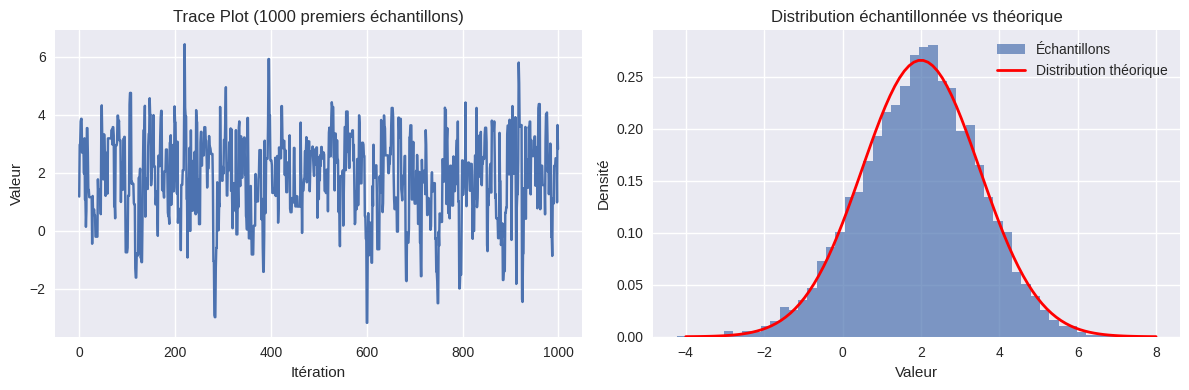

In [4]:
print("=== EXEMPLE 1: DISTRIBUTION NORMALE UNIVARIÉE ===")

def log_prob_normal(x, mu=0, sigma=1):
    """Log-probabilité d'une distribution normale"""
    return -0.5 * ((x - mu) / sigma)**2 - np.log(sigma * np.sqrt(2 * np.pi))

# Échantillonnage
samples_normal, acc_rate = metropolis_hastings(
    target_log_prob=lambda x: log_prob_normal(x, mu=2, sigma=1.5),
    proposal_func=normal_proposal,
    initial_state=np.array([0.0]),
    n_samples=10000,
    proposal_std=2.0
)

print(f"Taux d'acceptation: {acc_rate:.3f}")
print(f"Moyenne échantillonnée: {np.mean(samples_normal):.3f}")
print(f"Écart-type échantillonné: {np.std(samples_normal):.3f}")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Trace plot
ax1.plot(samples_normal[:1000, 0])
ax1.set_title('Trace Plot (1000 premiers échantillons)')
ax1.set_xlabel('Itération')
ax1.set_ylabel('Valeur')

# Histogramme vs distribution théorique
ax2.hist(samples_normal[:, 0], bins=50, density=True, alpha=0.7, label='Échantillons')
x_range = np.linspace(-4, 8, 100)
ax2.plot(x_range, stats.norm.pdf(x_range, 2, 1.5), 'r-', linewidth=2, label='Distribution théorique')
ax2.set_title('Distribution échantillonnée vs théorique')
ax2.set_xlabel('Valeur')
ax2.set_ylabel('Densité')
ax2.legend()

plt.tight_layout()
plt.show()

### Bivarié


=== EXEMPLE 2: DISTRIBUTION NORMALE BIVARIÉE ===
Taux d'acceptation: 0.411
Moyenne échantillonnée: [ 1.09688909 -0.93924802]
Matrice de covariance échantillonnée:
[[2.03514422 0.84086827]
 [0.84086827 0.99974915]]


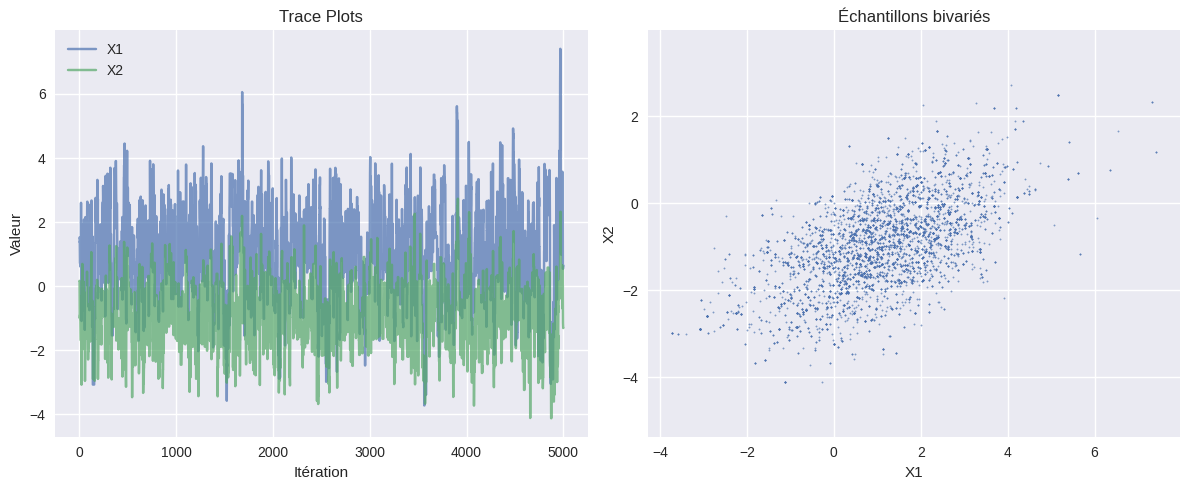

In [5]:
print("\n=== EXEMPLE 2: DISTRIBUTION NORMALE BIVARIÉE ===")

def log_prob_bivariate_normal(x, mu, Sigma):
    """Log-probabilité d'une distribution normale bivariée"""
    diff = x - mu
    return -0.5 * (diff.T @ np.linalg.inv(Sigma) @ diff + np.log(np.linalg.det(2 * np.pi * Sigma)))

# Paramètres de la distribution cible
mu_target = np.array([1, -1])
Sigma_target = np.array([[2, 0.8], [0.8, 1]])

# Échantillonnage
samples_biv, acc_rate_biv = metropolis_hastings(
    target_log_prob=lambda x: log_prob_bivariate_normal(x, mu_target, Sigma_target),
    proposal_func=normal_proposal,
    initial_state=np.array([0.0, 0.0]),
    n_samples=5000,
    proposal_std=1.5
)

print(f"Taux d'acceptation: {acc_rate_biv:.3f}")
print(f"Moyenne échantillonnée: {np.mean(samples_biv, axis=0)}")
print(f"Matrice de covariance échantillonnée:\n{np.cov(samples_biv.T)}")

# Visualisation bivariée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trace plots
ax1.plot(samples_biv[:, 0], label='X1', alpha=0.7)
ax1.plot(samples_biv[:, 1], label='X2', alpha=0.7)
ax1.set_title('Trace Plots')
ax1.set_xlabel('Itération')
ax1.set_ylabel('Valeur')
ax1.legend()

# Scatter plot avec contours
ax2.scatter(samples_biv[:, 0], samples_biv[:, 1], alpha=0.6, s=1)
ax2.set_title('Échantillons bivariés')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.axis('equal')

plt.tight_layout()
plt.show()

## ALGORITHME DE GIBBS SAMPLING

In [6]:
def gibbs_sampling(conditional_samplers, initial_state, n_samples, burn_in=1000):
    """
    Implémentation générale de l'algorithme de Gibbs Sampling
    
    Paramètres:
    -----------
    conditional_samplers : list
        Liste de fonctions pour échantillonner chaque variable conditionnellement
    initial_state : array
        État initial
    n_samples : int
        Nombre d'échantillons à générer
    burn_in : int
        Période de chauffe
    
    Retourne:
    ---------
    samples : array
        Échantillons générés
    """
    
    samples = []
    current_state = np.array(initial_state, dtype=float)
    n_vars = len(current_state)
    
    for i in range(n_samples + burn_in):
        # Mise à jour de chaque variable selon sa distribution conditionnelle
        for j in range(n_vars):
            current_state[j] = conditional_samplers[j](current_state)
        
        # Stockage après burn-in
        if i >= burn_in:
            samples.append(current_state.copy())
    
    return np.array(samples)

### Gibbs: Bivarié

In [7]:
# Exemple 1: Distribution normale bivariée avec Gibbs
print("\n=== EXEMPLE 3: GIBBS SAMPLING - NORMALE BIVARIÉE ===")

def conditional_x1_given_x2(state, mu1=1, mu2=-1, sigma1=np.sqrt(2), sigma2=1, rho=0.8/np.sqrt(2)):
    """Échantillonnage de X1 | X2"""
    x2 = state[1]
    cond_mean = mu1 + (sigma1/sigma2) * rho * (x2 - mu2)
    cond_var = sigma1**2 * (1 - rho**2)
    return np.random.normal(cond_mean, np.sqrt(cond_var))

def conditional_x2_given_x1(state, mu1=1, mu2=-1, sigma1=np.sqrt(2), sigma2=1, rho=0.8/np.sqrt(2)):
    """Échantillonnage de X2 | X1"""
    x1 = state[0]
    cond_mean = mu2 + (sigma2/sigma1) * rho * (x1 - mu1)
    cond_var = sigma2**2 * (1 - rho**2)
    return np.random.normal(cond_mean, np.sqrt(cond_var))

# Échantillonnage Gibbs
samplers = [conditional_x1_given_x2, conditional_x2_given_x1]
samples_gibbs = gibbs_sampling(samplers, [0, 0], n_samples=5000)

print(f"Moyenne Gibbs: {np.mean(samples_gibbs, axis=0)}")
print(f"Covariance Gibbs:\n{np.cov(samples_gibbs.T)}")


=== EXEMPLE 3: GIBBS SAMPLING - NORMALE BIVARIÉE ===
Moyenne Gibbs: [ 1.01577834 -0.97683302]
Covariance Gibbs:
[[1.98661996 0.79951313]
 [0.79951313 1.00231093]]


### Gibbs Régression Bayésienne


=== EXEMPLE 4: RÉGRESSION BAYÉSIENNE AVEC GIBBS ===
Coefficients vrais: [ 1  2 -1]
Sigma vrai: 0.5
Coefficients estimés (moyenne): [ 0.93421285  1.95579921 -0.97565618]
Sigma estimé (moyenne): 0.543


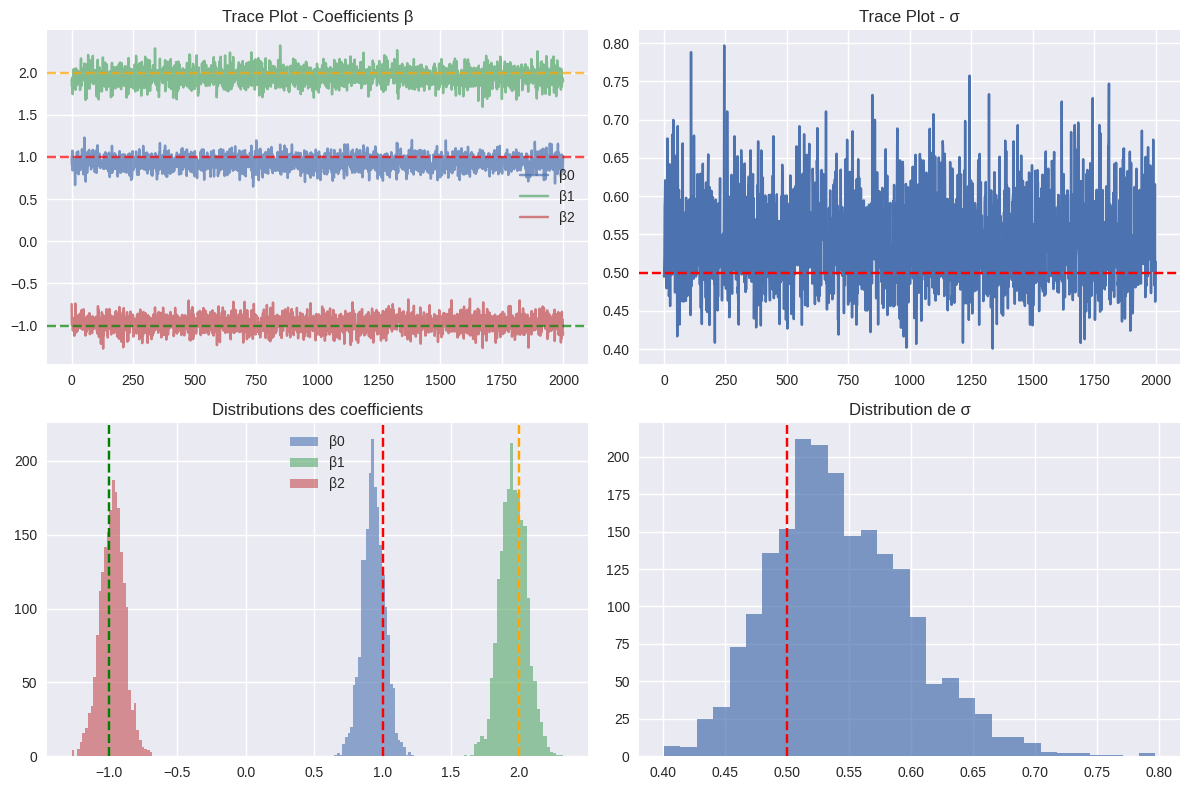

In [8]:
print("\n=== EXEMPLE 4: RÉGRESSION BAYÉSIENNE AVEC GIBBS ===")

# Génération de données synthétiques
n_obs = 50
X = np.random.randn(n_obs, 2)
X = np.column_stack([np.ones(n_obs), X])  # Ajout de l'intercept
beta_true = np.array([1, 2, -1])
sigma_true = 0.5
y = X @ beta_true + np.random.normal(0, sigma_true, n_obs)

# Priors
beta_prior_mean = np.zeros(3)
beta_prior_cov = 10 * np.eye(3)
sigma_prior_a = 1
sigma_prior_b = 1

def sample_beta_given_sigma(state):
    """Échantillonnage de beta | sigma, y"""
    sigma = state[3]
    
    # Distribution conditionnelle de beta (normale multivariée)
    precision_prior = np.linalg.inv(beta_prior_cov)
    precision_post = precision_prior + (1/sigma**2) * (X.T @ X)
    cov_post = np.linalg.inv(precision_post)
    
    mean_post = cov_post @ (precision_prior @ beta_prior_mean + (1/sigma**2) * X.T @ y)
    
    beta_new = np.random.multivariate_normal(mean_post, cov_post)
    state[:3] = beta_new
    return beta_new[0]  # Retourne la première composante (pour l'interface)

def sample_sigma_given_beta(state):
    """Échantillonnage de sigma | beta, y"""
    beta = state[:3]
    residuals = y - X @ beta
    
    # Distribution conditionnelle de sigma (Gamma inverse)
    a_post = sigma_prior_a + n_obs/2
    b_post = sigma_prior_b + 0.5 * np.sum(residuals**2)
    
    # Échantillonnage de la précision puis conversion en écart-type
    precision = np.random.gamma(a_post, 1/b_post)
    return 1/np.sqrt(precision)

def sample_beta_components(state):
    """Fonctions séparées pour chaque composante de beta"""
    sample_beta_given_sigma(state)
    return state[0]

def sample_beta1(state):
    sample_beta_given_sigma(state)
    return state[1]

def sample_beta2(state):
    sample_beta_given_sigma(state)
    return state[2]

# Échantillonnage Gibbs pour la régression
regression_samplers = [sample_beta_components, sample_beta1, sample_beta2, sample_sigma_given_beta]
samples_regression = gibbs_sampling(regression_samplers, [0, 0, 0, 1], n_samples=2000)

print(f"Coefficients vrais: {beta_true}")
print(f"Sigma vrai: {sigma_true}")
print(f"Coefficients estimés (moyenne): {np.mean(samples_regression[:, :3], axis=0)}")
print(f"Sigma estimé (moyenne): {np.mean(samples_regression[:, 3]):.3f}")

# Visualisation des résultats de régression
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Trace plots pour les coefficients
for i in range(3):
    axes[0, 0].plot(samples_regression[:, i], label=f'β{i}', alpha=0.7)
axes[0, 0].axhline(y=beta_true[0], color='red', linestyle='--', alpha=0.7)
axes[0, 0].axhline(y=beta_true[1], color='orange', linestyle='--', alpha=0.7)
axes[0, 0].axhline(y=beta_true[2], color='green', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Trace Plot - Coefficients β')
axes[0, 0].legend()

# Trace plot pour sigma
axes[0, 1].plot(samples_regression[:, 3])
axes[0, 1].axhline(y=sigma_true, color='red', linestyle='--')
axes[0, 1].set_title('Trace Plot - σ')

# Distributions marginales
for i in range(3):
    axes[1, 0].hist(samples_regression[:, i], bins=30, alpha=0.6, label=f'β{i}')
    axes[1, 0].axvline(x=beta_true[i], color=['red', 'orange', 'green'][i], linestyle='--')
axes[1, 0].set_title('Distributions des coefficients')
axes[1, 0].legend()

axes[1, 1].hist(samples_regression[:, 3], bins=30, alpha=0.7)
axes[1, 1].axvline(x=sigma_true, color='red', linestyle='--')
axes[1, 1].set_title('Distribution de σ')

plt.tight_layout()
plt.show()

## Comparaison


=== DIAGNOSTICS DE CONVERGENCE ===
Taille d'échantillon effective:
  β0: 1000.0
  β1: 1000.0
  σ:  881.9
R-hat pour β0: 1.000


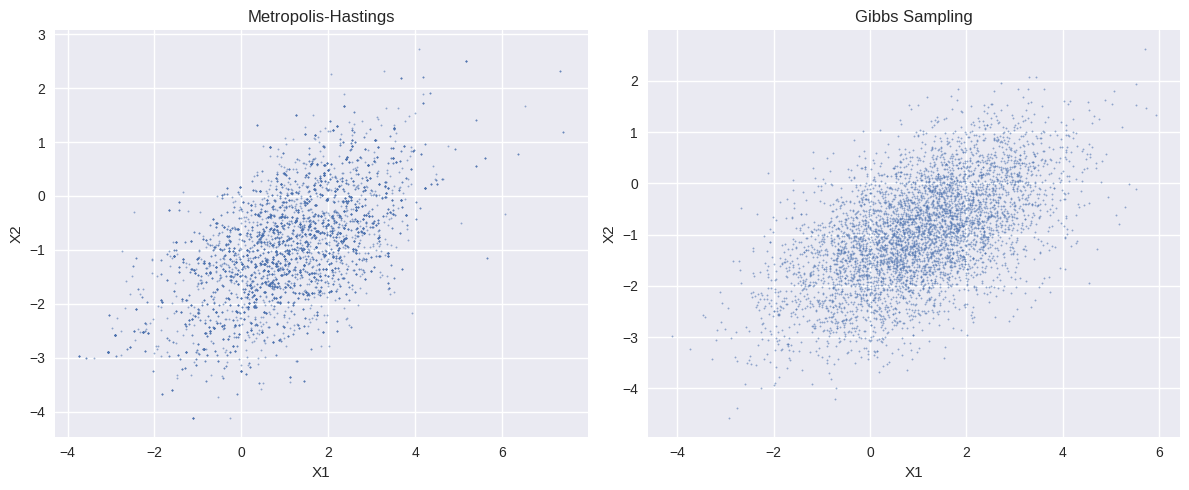

In [9]:
def effective_sample_size(x, max_lag=None):
    """Calcul de la taille d'échantillon effective"""
    n = len(x)
    if max_lag is None:
        max_lag = min(n//4, 200)
    
    # Centrer la série
    x_centered = x - np.mean(x)
    
    # Calcul de l'autocorrélation
    autocorr = np.correlate(x_centered, x_centered, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0]  # Normalisation
    
    # Trouver le premier lag où l'autocorrélation devient négative
    tau_int = 1
    for lag in range(1, min(max_lag, len(autocorr))):
        if autocorr[lag] <= 0:
            break
        tau_int += 2 * autocorr[lag]
    
    return n / (2 * tau_int)

def rhat_statistic(chains):
    """Calcul de la statistique R-hat de Gelman-Rubin"""
    m, n = chains.shape  # m chaînes, n échantillons
    
    # Moyennes par chaîne et globale
    chain_means = np.mean(chains, axis=1)
    overall_mean = np.mean(chain_means)
    
    # Variance intra-chaîne
    W = np.mean([np.var(chains[i], ddof=1) for i in range(m)])
    
    # Variance inter-chaîne
    B = n * np.var(chain_means, ddof=1)
    
    # Estimation de la variance
    var_est = (n-1)/n * W + B/n
    
    # R-hat
    rhat = np.sqrt(var_est / W)
    return rhat

print("\n=== DIAGNOSTICS DE CONVERGENCE ===")

# Calcul ESS pour les échantillons de régression
ess_beta0 = effective_sample_size(samples_regression[:, 0])
ess_beta1 = effective_sample_size(samples_regression[:, 1])
ess_sigma = effective_sample_size(samples_regression[:, 3])

print(f"Taille d'échantillon effective:")
print(f"  β0: {ess_beta0:.1f}")
print(f"  β1: {ess_beta1:.1f}")
print(f"  σ:  {ess_sigma:.1f}")

# Génération de plusieurs chaînes pour R-hat
n_chains = 4
chains_beta0 = []

for _ in range(n_chains):
    samples_chain = gibbs_sampling(regression_samplers, 
                                 np.random.randn(4), n_samples=1000)
    chains_beta0.append(samples_chain[:, 0])

chains_array = np.array(chains_beta0)
rhat_beta0 = rhat_statistic(chains_array)
print(f"R-hat pour β0: {rhat_beta0:.3f}")

# Visualisation finale - comparaison MH vs Gibbs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(samples_biv[:, 0], samples_biv[:, 1], alpha=0.5, s=1, label='Metropolis-Hastings')
ax1.set_title('Metropolis-Hastings')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

ax2.scatter(samples_gibbs[:, 0], samples_gibbs[:, 1], alpha=0.5, s=1, label='Gibbs Sampling')
ax2.set_title('Gibbs Sampling')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')

plt.tight_layout()
plt.show()